In [1]:
import numpy as np
import numpy.random as rd
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation as ani
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)

from tabulate import tabulate
from time import time

import pystan
from pystan import StanModel

from sklearn import cross_validation
from scipy.stats import gaussian_kde

In [2]:
pystan.__version__

'2.8.0.0'

【機械学習】モデル評価・指標についてのまとめと実行( w/Titanicデータセット)

http://qiita.com/kenmatsu4/items/0a862a42ceb178ba7155

で使った、数値に変換済みのTitanicデータを使用。

In [4]:
# import Titanic Data
titanic = pd.read_table("https://raw.githubusercontent.com/matsuken92/Qiita_Contents/master/PyStan-Titanic/data/titanic_converted.csv",
              sep=",", header=0)
titanic.head(10)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone
0,0,3,1,22,1,0,7.2500,1,3,1,1,0,3,1
1,1,1,0,38,1,0,71.2833,2,1,2,0,3,1,0
2,1,3,0,26,0,0,7.9250,1,3,2,0,0,3,0
3,1,1,0,35,1,0,53.1000,1,1,2,0,3,3,0
4,0,3,1,35,0,0,8.0500,1,3,1,1,0,3,1
5,0,3,1,28,0,0,8.4583,3,3,1,1,0,2,1
6,0,1,1,54,0,0,51.8625,1,1,1,1,5,3,1
7,0,3,1,2,3,1,21.0750,1,3,0,0,0,3,0
8,1,3,0,27,0,2,11.1333,1,3,2,0,0,3,0
9,1,2,0,14,1,0,30.0708,2,2,0,0,0,1,0


In [5]:
headers = [c for c in titanic.columns]
headers.insert(0,"ID")
print tabulate(titanic[0:10], headers, tablefmt="pipe")

|   ID |   survived |   pclass |   sex |   age |   sibsp |   parch |    fare |   embarked |   class |   who |   adult_male |   deck |   embark_town |   alone |
|-----:|-----------:|---------:|------:|------:|--------:|--------:|--------:|-----------:|--------:|------:|-------------:|-------:|--------------:|--------:|
|    0 |          0 |        3 |     1 |    22 |       1 |       0 |  7.25   |          1 |       3 |     1 |            1 |      0 |             3 |       1 |
|    1 |          1 |        1 |     0 |    38 |       1 |       0 | 71.2833 |          2 |       1 |     2 |            0 |      3 |             1 |       0 |
|    2 |          1 |        3 |     0 |    26 |       0 |       0 |  7.925  |          1 |       3 |     2 |            0 |      0 |             3 |       0 |
|    3 |          1 |        1 |     0 |    35 |       1 |       0 | 53.1    |          1 |       1 |     2 |            0 |      3 |             3 |       0 |
|    4 |          0 |        3 |     1 |

In [6]:
target = titanic.ix[:, 0]
# data = titanic.ix[:, [1,2,3,4,5,6,7,8,9,10,11,12,13]]
data = titanic.ix[:, [1,2,3,4,5,6]]

In [7]:
# 訓練データ(80%), テストデータ(20%)に分割する
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.2, random_state=0)

print [d.shape for d in [X_train, X_test, y_train, y_test]]

[(712, 6), (179, 6), (712,), (179,)]


In [8]:
dat = {'N': X_train.shape[0], 'M': X_train.shape[1], 'X': X_train, 'y': y_train}

In [9]:
code = """
        data {
            int<lower=0> N;
            int<lower=0> M;
            matrix[N, M] X;
            int<lower=0, upper=1> y[N];
        } parameters {
            real beta0;
            vector[M] beta; 
        } model {
            for (i in 1:N)
                y[i] ~ bernoulli(inv_logit (beta0 + dot_product(X[i] , beta)));
        }
        """

In [10]:
%time stm = StanModel(model_code=code)

CPU times: user 1.36 s, sys: 113 ms, total: 1.48 s
Wall time: 15.4 s


In [11]:
n_itr = 3000
n_warmup = 200
chains = 2

%time fit = stm.sampling(data=dat, iter=n_itr, chains=chains, n_jobs=-1, warmup=n_warmup, algorithm="NUTS", verbose=False)
la    = fit.extract(permuted=True)  # return a dictionary of arrays
names = fit.model_pars 

n_param = np.sum([1 if len(x) == 0 else x[0] for x in fit.par_dims])

CPU times: user 156 ms, sys: 59.1 ms, total: 215 ms
Wall time: 5min 24s


/Users/matsuken/anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/matsuken/anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)


In [12]:
print fit

Inference for Stan model: anon_model_b12e3f2368679a0c562b9f74618b2f82.
2 chains, each with iter=3000; warmup=200; thin=1; 
post-warmup draws per chain=2800, total post-warmup draws=5600.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0     5.02  8.0e-3    0.6   3.89   4.61   5.01   5.42   6.23 5600.0    1.0
beta[0]  -1.04  2.1e-3   0.15  -1.35  -1.15  -1.04  -0.93  -0.75 5600.0    1.0
beta[1]  -2.77  3.0e-3   0.23  -3.22  -2.92  -2.76  -2.61  -2.33 5600.0    1.0
beta[2]  -0.04  1.2e-4 8.9e-3  -0.06  -0.05  -0.04  -0.04  -0.03 5600.0    1.0
beta[3]  -0.41  1.6e-3   0.12  -0.66  -0.49  -0.41  -0.33  -0.18 5600.0    1.0
beta[4]  -0.08  1.8e-3   0.14  -0.35  -0.17  -0.08   0.02   0.18 5600.0    1.0
beta[5] 2.5e-3  3.4e-5 2.5e-3-2.3e-3 7.0e-4 2.4e-3 4.1e-3 7.7e-3 5600.0    1.0
lp__    -322.4    0.02   1.86 -326.8 -323.4 -322.0 -321.0 -319.7 5600.0    1.0

Samples were drawn using NUTS(diag_e) at Sun Dec 13 02:53:45 2015.
For each parameter, n_eff is a cr

In [13]:
# 各パラメーターのEAP推定量リスト抽出
mean_list = np.array(fit.summary()['summary'])[:,0]

In [14]:
# 各パラメーターのEMAP推定量のリスト生成
ddd = la['beta0']
def find_MAP(data):
    kde = gaussian_kde(data)
    x_range = np.linspace(min(data), max(data), 501)
    eval_kde = kde.evaluate(x_range)
    #plt.plot(x_range, eval_kde)
    return x_range[np.argmax(eval_kde)]

MAP_list = []
MAP_list.append(find_MAP(ddd))
for i in range(n_param-1):
    MAP_list.append(find_MAP(la['beta'][:,i]))

/Users/matsuken/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


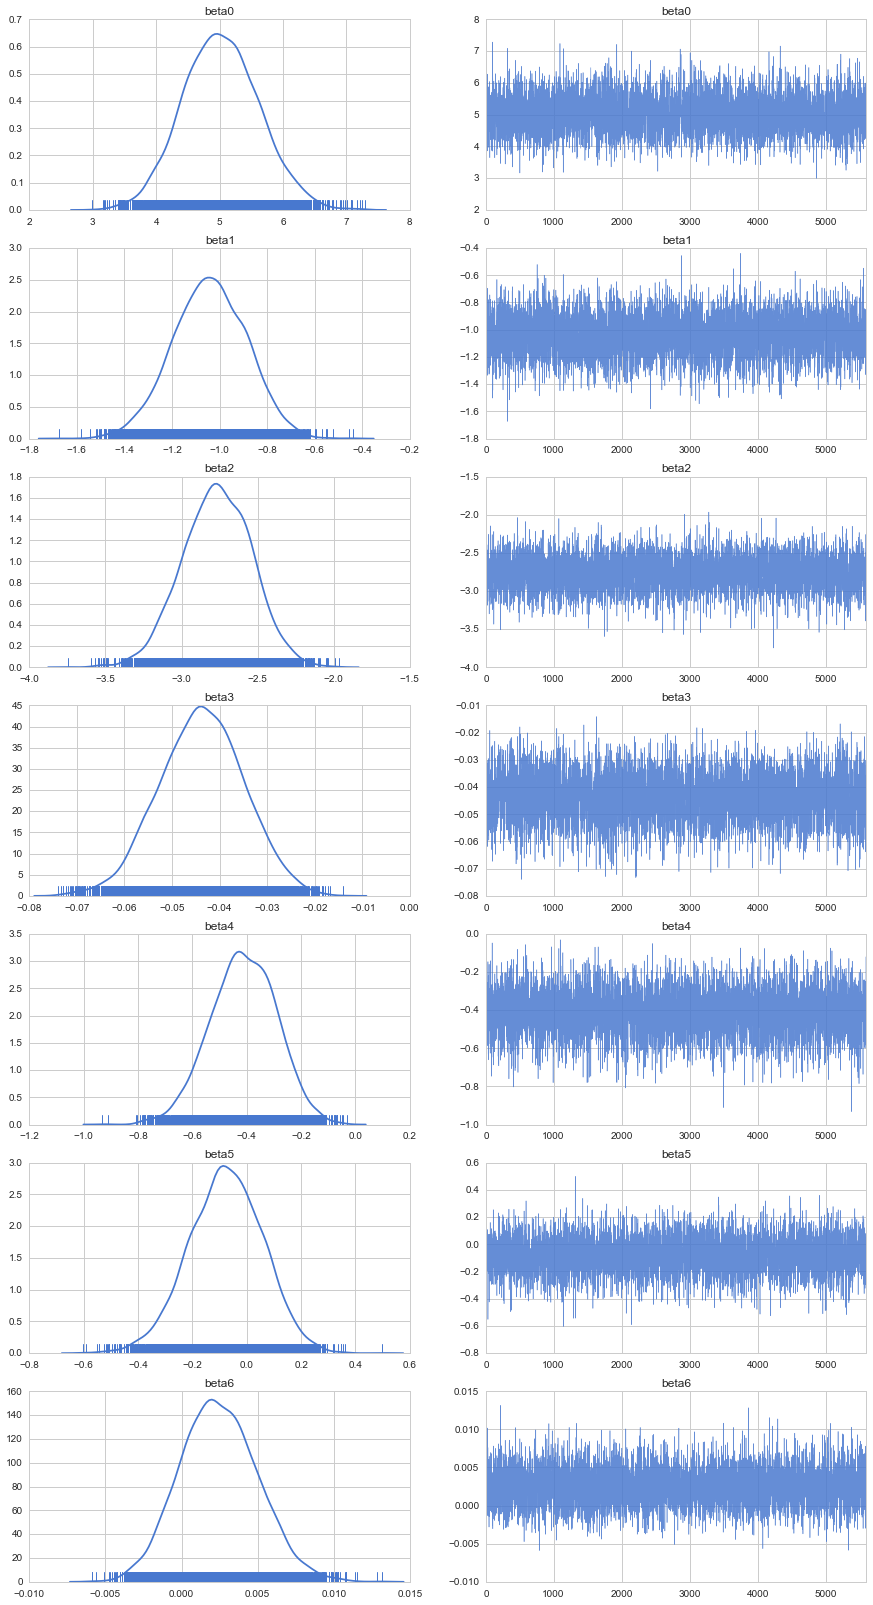

In [15]:
f, axes = plt.subplots(n_param, 2, figsize=(15, 4*n_param))
cnt = 0
for name in names:
    dat = la[name]
    if dat.ndim == 2:
        for j in range(dat.shape[1]):
            d = dat[:,j]
            sns.distplot(d, hist=False, rug=True, ax=axes[cnt, 0])
            sns.tsplot(d,   alpha=0.8, lw=.5, ax=axes[cnt, 1])
            cnt += 1
    else:
        # Intercept
        sns.distplot(dat, hist=False, rug=True, ax=axes[cnt, 0])
        sns.tsplot(dat,   alpha=0.8, lw=.5, ax=axes[cnt, 1])
        cnt += 1

name_list = []
for name in names:
    if la[name].ndim == 2:
        for i in range(dat.shape[1]):
            name_list.append("{}{}".format(name,i+1))
    else:
        name_list.append(name)

for i in range(2):
    for j, t in enumerate(name_list):
        axes[j, i].set_title(t)
plt.show()


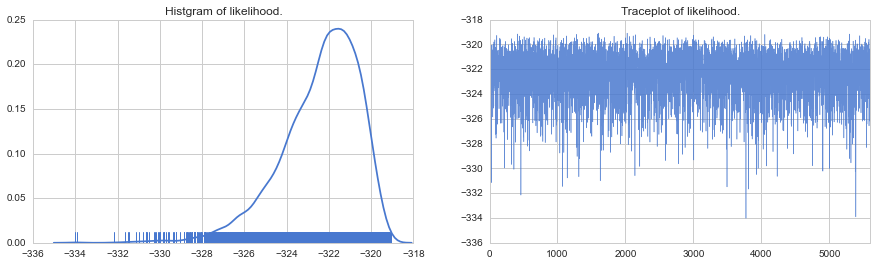

In [16]:
# Likelihood
f, axes = plt.subplots(1, 2, figsize=(15, 4))

sns.distplot(la['lp__'], hist=False, rug=True, ax=axes[0])
sns.tsplot(la['lp__'],   alpha=0.8, lw=.5, ax=axes[1])
axes[0].set_title("Histgram of likelihood.")
axes[1].set_title("Traceplot of likelihood.")
plt.show()

In [17]:
param = mean_list[0:7]

In [18]:
def logis(x, beta):
    assert len(beta) == 7
    assert len(beta) == 7
    if type(x) != 'np.array':
        x = np.array(x)
    tmp = [1]
    tmp.extend(x)
    x = tmp
    return (1+np.exp(-np.dot(x, beta)))**(-1)

In [39]:
def check_accuracy(data, target, param, threshold = 0.5):
    ans_list = []
    for i in range(len(data)):
        idx = data.index[i]
        res = logis(data.ix[idx], param)
        ans = 1 if res > threshold else 0
        ans_list.append(ans == target.ix[idx])

    return np.mean(ans_list)
    
print u"[train][EAP] Accuracy:{0:.5f}".format(check_accuracy(X_train, y_train, param))
print u"[train][MAP] Accuracy:{0:.5f}".format(check_accuracy(X_train, y_train, MAP_list))

print "[test][EAP] Accuracy:{0:.5f}".format(check_accuracy(X_test, y_test, param))
print "[test][MAP] Accuracy:{0:.5f}".format(check_accuracy(X_test, y_test, MAP_list))

[train][EAP] Accuracy:0.79073
[train][MAP] Accuracy:0.80618
[test][EAP] Accuracy:0.81006
[test][MAP] Accuracy:0.79888


### 参考
http://aaaazzzz036.hatenablog.com/entry/2013/11/06/225417
 → Stanコードを参考とさせていただきました。